In [1]:
import os
import glob
import numpy as np
import xml.dom.minidom
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_folder(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [3]:
dir_path = '/media/vincentwu-cmlab/7C5650545650116E/NucleusSegData/NucleusSegData/'
dataset_list = ['TrainingSet', 'HepG2TestSet', 'Huh7TestSet']

In [4]:
create_folder('NucleusSegData')
for dataset in dataset_list:
    create_folder('NucleusSegData/' + dataset)
    img_list = glob.glob(dir_path + dataset + '/*.jpg')
    ann_list = glob.glob(dir_path + dataset + '/*ann*')
    for img_path, ann_path in zip(img_list, ann_list):
        #print(img_path, ann_path)
        name = img_path.split('/')[-1].split('.')[0]
        create_folder('NucleusSegData/' + dataset + '/' + name)
        create_folder('NucleusSegData/' + dataset + '/' + name + '/image')
        create_folder('NucleusSegData/' + dataset + '/' + name + '/masks')
        img = Image.open(img_path)
        img.save('NucleusSegData/' + dataset + '/' + name + '/image/' + name + '.png')
        ann = np.loadtxt(ann_path)
        for i in range(1, len(np.unique(ann))):
            mask = np.zeros(ann.shape)
            mask[np.where(ann==i)]=255
            mask = Image.fromarray(mask).convert('L')
            mask.save('NucleusSegData/' + dataset + '/' + name + '/masks/'+'mask_{:0>5}.png'.format(i-1))

In [5]:
import os
import random
import numpy as np
import skimage
from utils import utils
from utils import visualize
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class MonusegDataset(utils.Dataset):

    def load_monuseg(self, dataset_dir):
        """Load a subset of the monuseg dataset.

        dataset_dir: Root directory of the dataset
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("nuclear", 1, "nuclear")
        # Get image ids from directory names
        image_ids = next(os.walk(dataset_dir))[1]
        
        # Add images
        for image_id in image_ids:
            self.add_image(
                "nuclear",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "image/{}.png".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")

        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    
    def read_data_and_mask_arr(self):
        print("Reading data array & mask array from disk")
        self.image_arr = np.array([self.load_image(x) for x in self._image_ids])
        
        # Since maks has different depth in each image, we store mask arr in dict
        self.mask_arr = {}
        for i in self._image_ids:
            self.mask_arr[i] = self.load_mask(i)[0]
        
    def load_mask_arr(self, mask_arr, image_id):
        """Get instance masks from image array
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        mask = self.mask_arr[image_id]
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclear":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [7]:
dataset = MonusegDataset()
dataset.load_monuseg("/home/vincentwu-cmlab/cell_data/NucleusSegData/TrainingSet")

In [8]:
# Must call before using the dataset
dataset.prepare()

In [9]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 10
Class Count: 2
  0. BG                                                
  1. nuclear                                           


## Display Samples

Load and display images and masks.

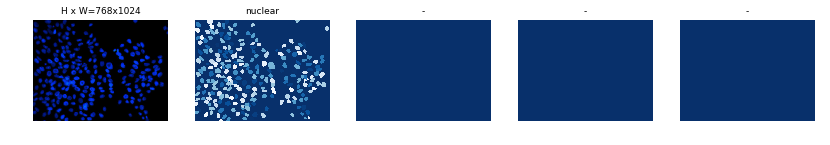

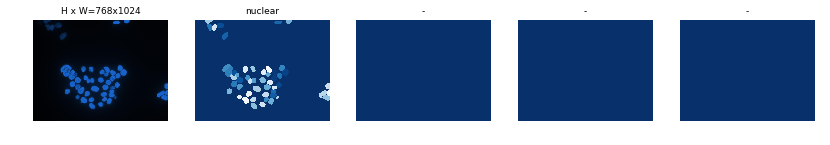

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  6 tr10
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (768, 1024, 176)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (176,)                min:    1.00000  max:    1.00000  int32
bbox                     shape: (176, 4)              min:    0.00000  max: 1024.00000  int32


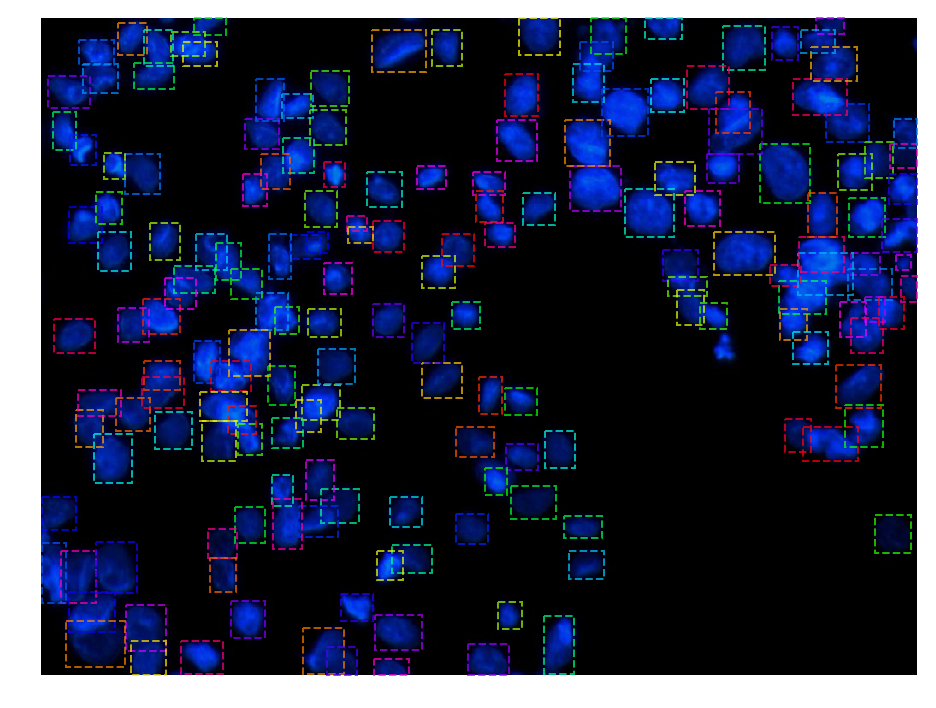

In [11]:
# Load random image and mask.
#image_id = random.choice(dataset.image_ids)
image_id = 6
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
utils.log("image", image)
utils.log("mask", mask)
utils.log("class_ids", class_ids)
utils.log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, show_bbox=True, show_mask=False)

image_id  6 tr10
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (768, 1024, 176)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (176,)                min:    1.00000  max:    1.00000  int32
bbox                     shape: (176, 4)              min:    0.00000  max: 1024.00000  int32


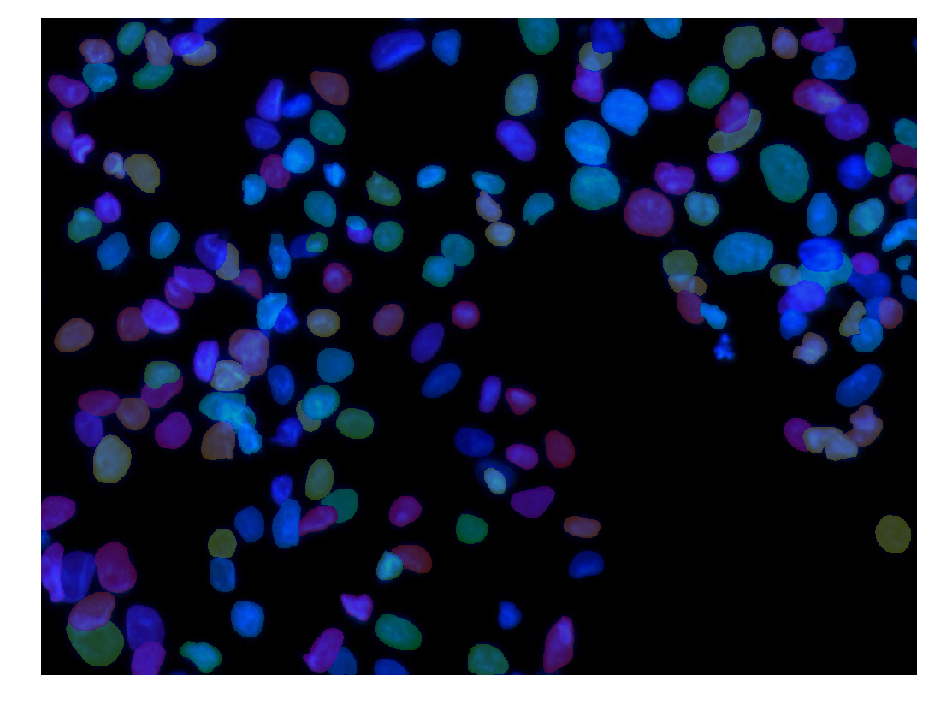

In [12]:
# Load random image and mask.
#image_id = random.choice(dataset.image_ids)
image_id = 6
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
utils.log("image", image)
utils.log("mask", mask)
utils.log("class_ids", class_ids)
utils.log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            captions=False, show_bbox=False, alpha=0.25)